<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

sfrerich

Aim: Preprocess annotated mouse brain single-cell data from Tabula Muris (Schaum 2018 Nature)

In [1]:
import sys
import os, fnmatch 

In [2]:
import anndata
import scanpy as sc
import scipy as sci
#sc.logging.print_versions()

In [3]:
sc.settings.verbosity = 3

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [5]:
from datetime import date
from matplotlib.pyplot import rc_context

In [6]:
os.getcwd()

'\\\\isdsynnas.srv.med.uni-muenchen.de\\BD-Dichgans\\SF\\Git\\p6-foxf2-per-celltype'

In [7]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load + format data

## Annotated by authors

Code mostly derived from: 01_collect_mouse_brain_studies.ipynb from Maren Buettner (see P6_vasc_scRNAseq/DropViz/all_by_region/)

Using FACS sorted cells, from:  
 -Brain_Myeloid-counts.csv  
 -Brain_Non-Myeloid-counts.csv

Publication: https://www.nature.com/articles/s41586-018-0590-4  
Downloaded from: https://figshare.com/articles/dataset/Single-cell_RNA-seq_data_from_Smart-seq2_sequencing_of_FACS_sorted_cells/5715040

In [8]:
# adata_tamu_myel = sc.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/FACS/Brain_Myeloid-counts.csv').T

In [10]:
# adata_tamu_nonmyel = sc.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/FACS/Brain_Non-Myeloid-counts.csv').T

In [11]:
# download source differs somehow to the one used by Maren Buettner. I assume Brain_Myeloid-counts equals Brain_Microglia-counts.csv.

In [12]:
adata_tamu_myel = sc.read_csv(main_dir+'/P6_vasc_scRNAseq/TabulaMuris2018/FACS/Brain_Microglia-counts.csv').T

In [13]:
adata_tamu_nonmyel = sc.read_csv(main_dir+'/P6_vasc_scRNAseq/TabulaMuris2018/FACS/Brain_Neurons-counts.csv').T

In [14]:
adata_tamu_myel

AnnData object with n_obs × n_vars = 4762 × 23433

In [15]:
adata_tamu_nonmyel

AnnData object with n_obs × n_vars = 5799 × 23433

Merge brain dataset objects from Tabula Muris. 

In [16]:
adata_tamu = adata_tamu_myel.concatenate(adata_tamu_nonmyel)

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [17]:
adata_tamu

AnnData object with n_obs × n_vars = 10561 × 23433
    obs: 'batch'

Convert Tabula Muris dataset into a sparse matrix.

In [18]:
adata_tamu.X = sci.sparse.csr_matrix(adata_tamu.X)

In [19]:
test = [x for x in adata_tamu.obs_names.str.split('-')]

In [20]:
adata_tamu.obs_names = [x[0] for x in test]

Load annotation file.

In [21]:
anno_tamu = pd.read_csv(main_dir+'/P6_vasc_scRNAseq/TabulaMuris2018/annotations_FACS.csv', 
                        low_memory=False)
meta_tamu = pd.read_csv(main_dir+'/P6_vasc_scRNAseq/TabulaMuris2018/metadata_FACS.csv')

In [22]:
# anno_tamu = pd.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/annotations_FACS.csv', 
#                         low_memory=False)
# meta_tamu = pd.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/metadata_FACS.csv')

In [23]:
anno_tamu.shape

(42192, 5)

In [24]:
anno_tamu.columns

Index(['cell', 'tissue', 'cell_ontology_class', 'cell_ontology_term_iri',
       'cell_ontology_id'],
      dtype='object')

In [25]:
red_idx2 = np.isin(adata_tamu.obs.index, anno_tamu.cell)

In [26]:
red_idx2.sum()

7365

In [27]:
adata_tamu = adata_tamu[red_idx2,:]

In [28]:
red_idx = np.isin(anno_tamu.cell,adata_tamu.obs.index)

In [29]:
anno_tamu_red = anno_tamu.loc[red_idx ,:]

In [30]:
anno_tamu_red.index = anno_tamu_red.cell

In [31]:
# OWN DATA SOURCE
pd.value_counts(anno_tamu_red.cell_ontology_class)

microglial cell                     4329
oligodendrocyte                     1186
endothelial cell                     625
astrocyte of the cerebral cortex     403
oligodendrocyte precursor cell       202
neuron                               196
unknown                              176
brain pericyte                       132
macrophage                            36
neuronal stem cell                    36
Bergmann glial cell                   30
smooth muscle cell                    14
Name: cell_ontology_class, dtype: int64

In [ ]:
# BÜTTNER DATA SOURCE
pd.value_counts(anno_tamu_red.cell_ontology_class)

microglial cell                     4394
oligodendrocyte                     1574
endothelial cell                     715
astrocyte of the cerebral cortex     432
neuron                               281
oligodendrocyte precursor cell       203
brain pericyte                       156
macrophage                            61
Bergmann glial cell                   40
Name: cell_ontology_class, dtype: int64

Note: datasets are slightly different, which should not be an issue

In [32]:
adata_tamu.obs['cell_ontology_class'] = anno_tamu_red.cell_ontology_class
adata_tamu.obs['cell_ontology_class'] = adata_tamu.obs['cell_ontology_class'].astype('category')
adata_tamu.obs['cell_ontology_id'] = anno_tamu_red.cell_ontology_id
adata_tamu.obs['cell_ontology_id'] = adata_tamu.obs['cell_ontology_id'].astype('category')

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_10612\2783267983.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_tamu.obs['cell_ontology_class'] = anno_tamu_red.cell_ontology_class


In [33]:
# adata_tamu.obs['region'] = anno_tamu_red.subtissue
# adata_tamu.obs['region'].loc[pd.isnull(adata_tamu.obs['region'])] ='Unknown'
# adata_tamu.obs['region'] = adata_tamu.obs['region'].astype('category')

In [34]:
# adata_tamu.obs['region'].cat.categories

Rename regions to fit with the other data sets.

In [35]:
# tabula_dict = dict({'Cerebellum' : 'CB', 
#                     'Cortex' : 'CTX', 
#                     'Hippocampus' : 'HC', 
#                     'Striatum' : 'STR'})

In [36]:
# adata_tamu.obs['region'] = adata_tamu.obs['region'].cat.rename_categories(tabula_dict)

In [37]:
# adata_tamu.obs['region'].value_counts()

In [38]:
adata_tamu.obs['study'] = 'Tabula_Muris'

In [39]:
adata_tamu.obs['cell_ontology_class'].cat.categories

Index(['Bergmann glial cell', 'astrocyte of the cerebral cortex',
       'brain pericyte', 'endothelial cell', 'macrophage', 'microglial cell',
       'neuron', 'neuronal stem cell', 'oligodendrocyte',
       'oligodendrocyte precursor cell', 'smooth muscle cell', 'unknown'],
      dtype='object')

Apply own re-ordering of annotation according to cell types of interest:

In [40]:
# # previous from Büttner:
# adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_ontology_class'].cat.add_categories(['astrocyte'])

# adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
#                                      ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'astrocyte'

# adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_type'].cat.remove_unused_categories()

In [41]:
# Novel:

In [42]:
adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_ontology_class'].cat.add_categories(['Oligos','Endothelial cells','OPCs','Neurons','Pericytes','Microglia/Macrophages','Unknown','Neuronal stem cells','SMCs','Astrocytes'])

In [43]:
adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'Astrocytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte'])] =  'Oligos'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['endothelial cell'])] =  'Endothelial cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte precursor cell'])] =  'OPCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuron'])] =  'Neurons'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['brain pericyte'])] =  'Pericytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['macrophage','microglial cell'])] =  'Microglia/Macrophages'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['unknown'])] =  'Unknown'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuronal stem cell'])] =  'Neuronal stem cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['smooth muscle cell'])] =  'SMCs'

In [44]:
adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_type'].cat.remove_unused_categories()

In [45]:
adata_tamu.obs['cell_type'].value_counts()

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
Pericytes                 132
Neuronal stem cells        36
SMCs                       14
Name: cell_type, dtype: int64

Remove ERCC tags from genes.

In [46]:
ercc_idx = np.array([tag.startswith('ERCC') for tag in adata_tamu.var_names])

In [47]:
adata_tamu = adata_tamu[:, np.invert(ercc_idx)].copy()

In [48]:
adata=adata_tamu

In [49]:
del adata_tamu

# QC

Not required because already annotated

normalizing counts per cell
    finished (0:00:00)


D:\Programme\Anaconda\envs\squidpy\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


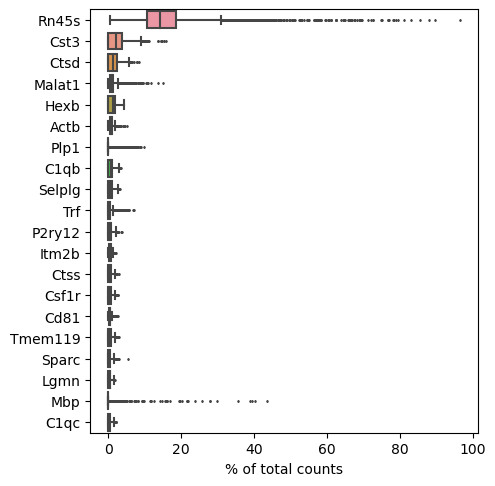

In [50]:
# genes with highest fraction of counts per cell
sc.pl.highest_expr_genes(adata, n_top=20, )

# Normalisation, logarithmization

Check if data is normalized:

In [51]:
adata.layers

Layers with keys: 

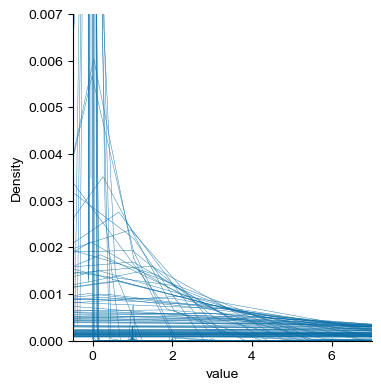

In [53]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, adata.X.shape[1]), 100)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
sns.set_theme(style='white')
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));

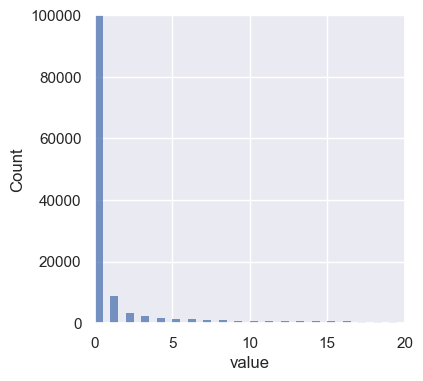

In [54]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [55]:
exp

0      1    2    3     4    5      6    7    8      9   ...    90   91  \
0     0.0    0.0  0.0  0.0   0.0  1.0  420.0  0.0  0.0    0.0  ...  29.0  0.0   
1     0.0  101.0  0.0  0.0  57.0  0.0    0.0  0.0  0.0  169.0  ...   0.0  0.0   
2     0.0    0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0    0.0  ...   0.0  0.0   
3     0.0    0.0  0.0  0.0   0.0  0.0   30.0  0.0  0.0    4.0  ...   0.0  0.0   
4     0.0    0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0    0.0  ...   0.0  0.0   
...   ...    ...  ...  ...   ...  ...    ...  ...  ...    ...  ...   ...  ...   
7360  0.0    0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0    0.0  ...  10.0  0.0   
7361  0.0    0.0  0.0  0.0   0.0  0.0    1.0  0.0  0.0    0.0  ...   0.0  0.0   
7362  0.0    0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0    0.0  ...   6.0  0.0   
7363  0.0    0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0    0.0  ...   0.0  0.0   
7364  0.0    0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0    0.0  ...   0.0  0.0   

       92   93   94     95    96     97   98     99  
0     0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  
1     0.0  0.0  0.0    0.0   0.0    0.0  0.0  104.0  
2     0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  
3     0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  
4     0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  
...   ...  ...  ...    ...   ...    ...  ...    ...  
7360  0.0  0.0  0.0  627.0   0.0  468.0  0.0    0.0  
7361  0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  
7362  0.0  0.0  0.0    0.0  24.0  303.0  0.0    0.0  
7363  0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  
7364  0.0  0.0  0.0    0.0  25.0  162.0  0.0    0.0  

[7365 rows x 100 columns]

In [56]:
adata.layers["counts"] = adata.X.copy() # save unnormalized raw RNA counts - retrieve via adata.X = adata.layers["counts"]

In [57]:
sc.pp.normalize_total(adata, inplace=True) # Normalize each spot by total counts over all genes, so that every spot has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


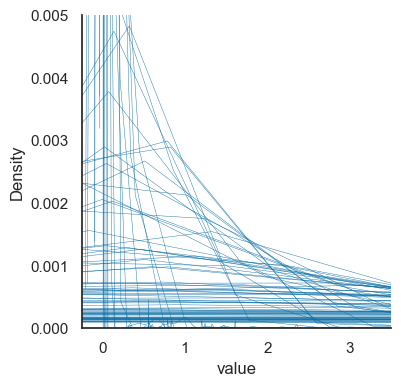

In [60]:
# show expression of 100 random genes (across all spots)
sns.set_theme(style='white')
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))

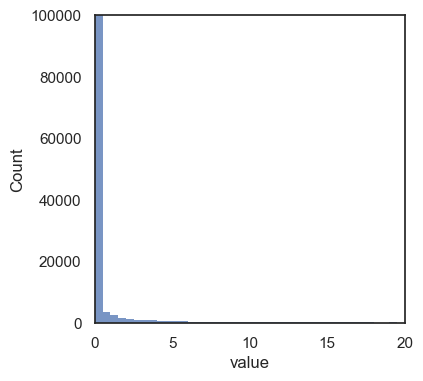

In [61]:
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [62]:
sc.pp.log1p(adata) # X = log(X + 1)

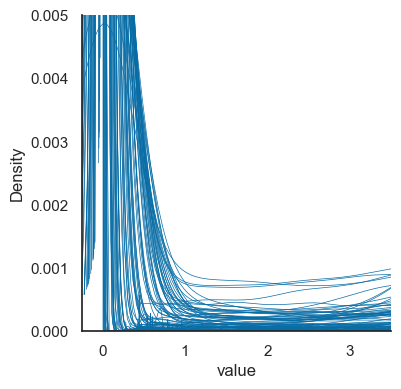

In [63]:
# show expression of 100 random genes (across all spots)
sns.set_theme(style='white')
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));

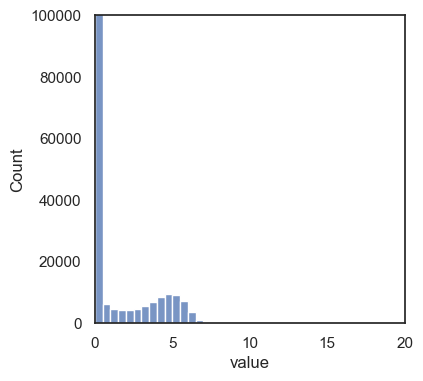

In [64]:
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [65]:
adata.layers["normalized"] = adata.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


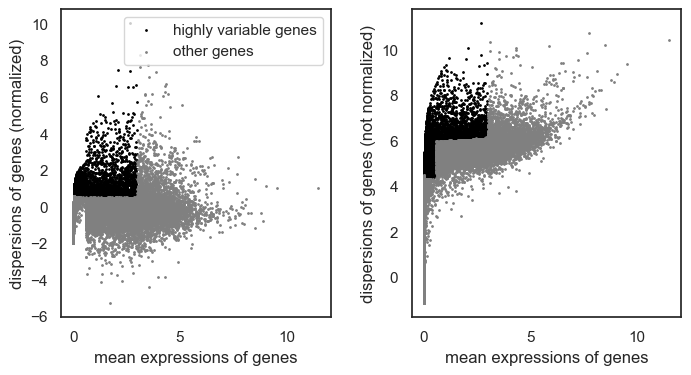

In [66]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [67]:
adata

AnnData object with n_obs × n_vars = 7365 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [68]:
adata.layers

Layers with keys: counts, normalized

# Dim Reduction

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


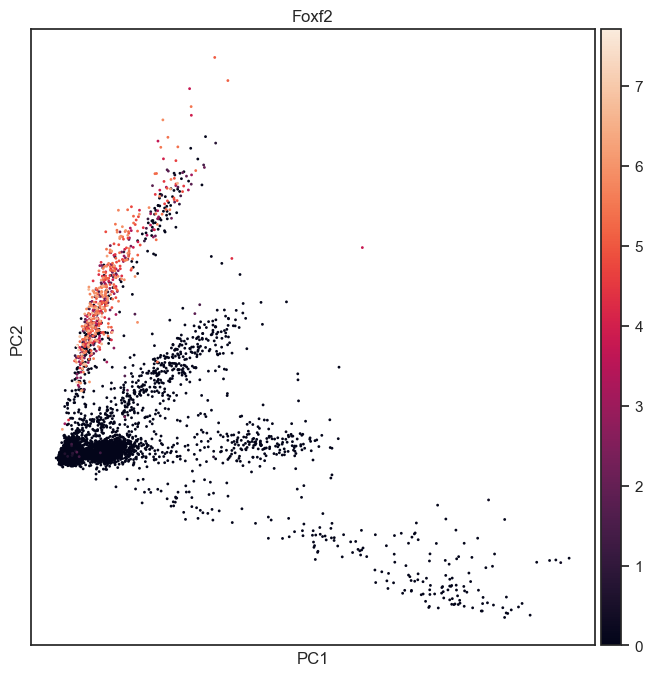

In [69]:
# Run PCA
with rc_context({'figure.figsize': (8, 8)}):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata, color='Foxf2')

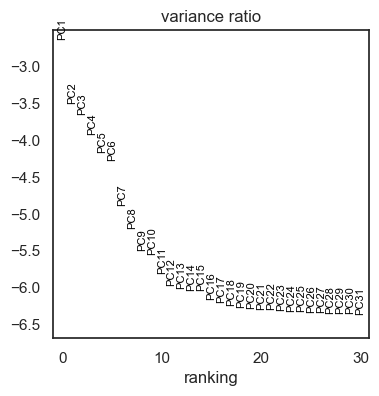

In [70]:
sc.pl.pca_variance_ratio(adata, log=True)

In [71]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [72]:
# Run UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


In [73]:
list(adata.obs.columns)

['batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type']

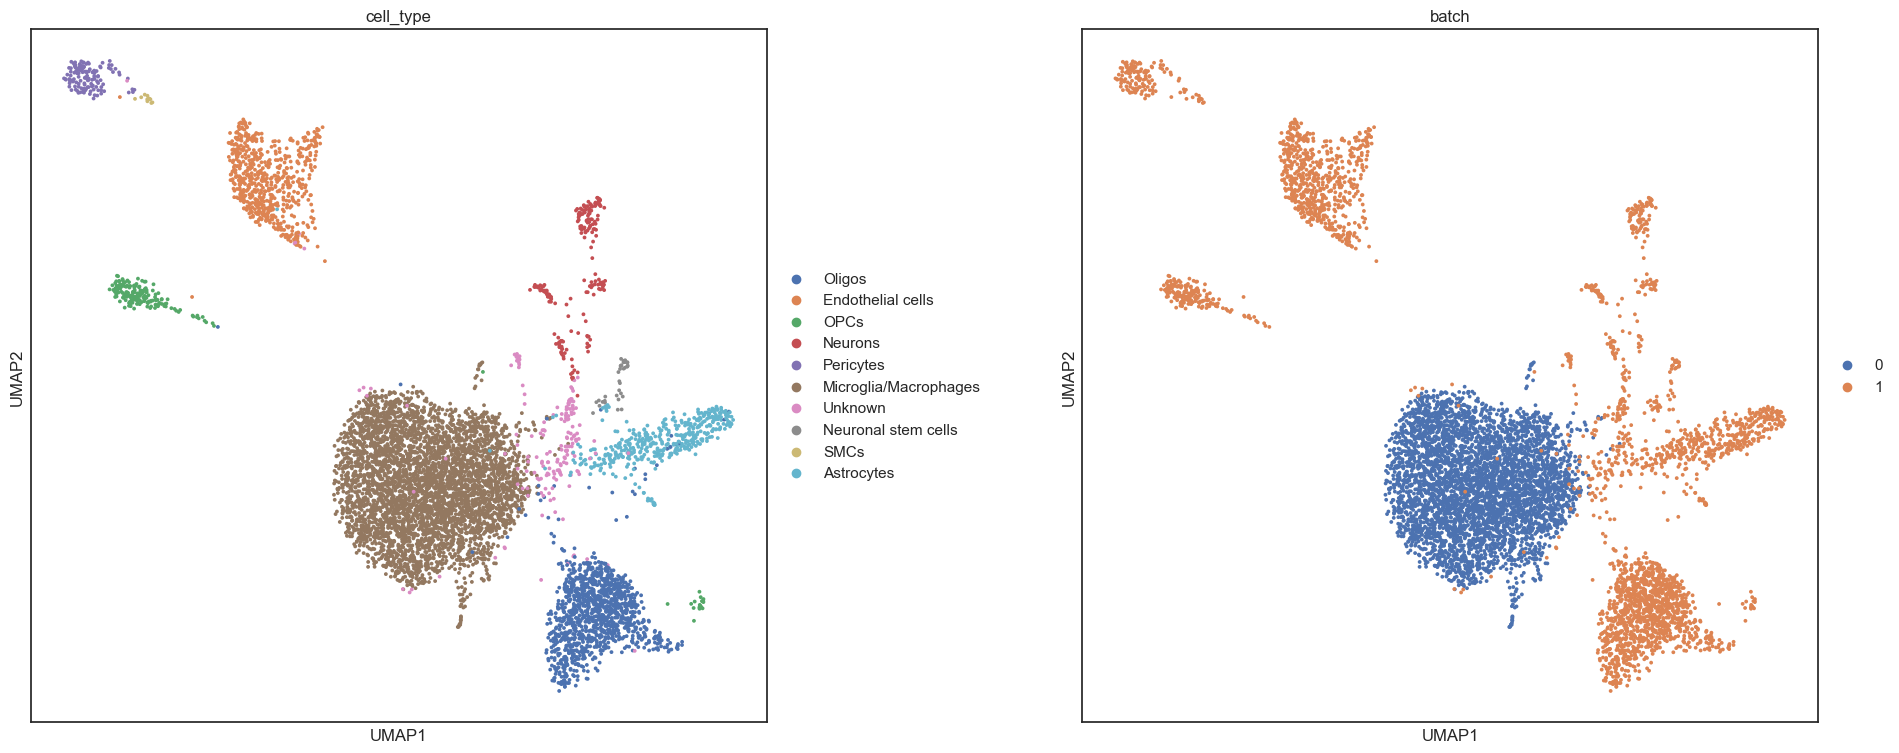

In [74]:
with rc_context({'figure.figsize': (9, 9)}):
    sc.pl.umap(adata, color=['cell_type', 'batch'], wspace=0.3, size=30)

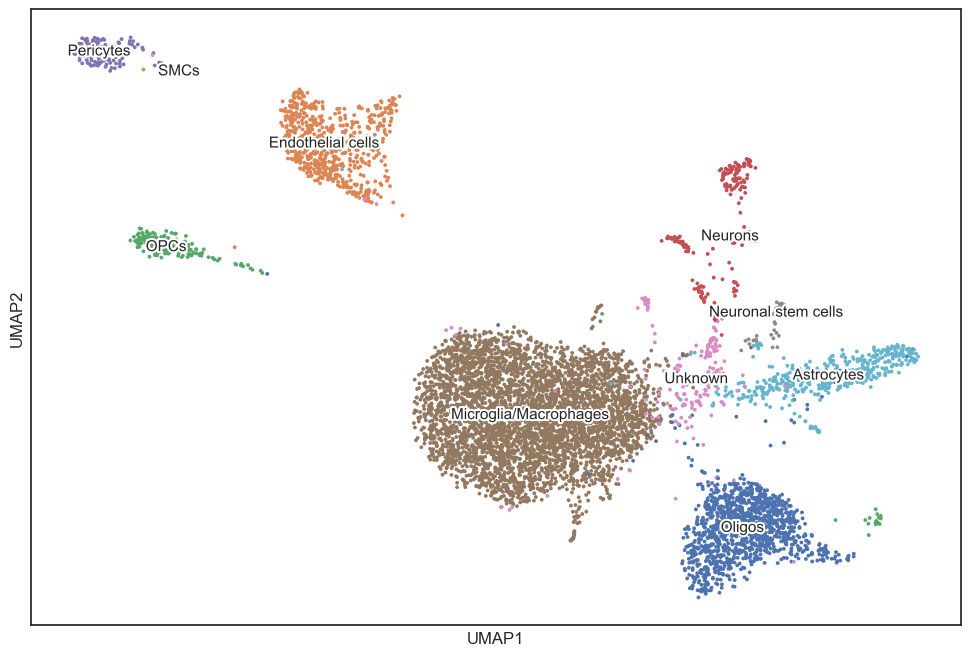

In [75]:
plt.rcParams['figure.figsize'] = [12, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=3, legend_fontsize=11, size=30)

Note: UMAP not very nice, but I will stick to pre-annotated cell types

# Cell annotation

Manual marker gene selection

|Vascular     |EC         |Pericytes|SMCs   |Fibroblasts|Oligos|OPCs         |Ependymal|Neurons    |immature/migrating Neurons|Astrocytes|Microglia|Immune (broad/hematopoetic)|Macrophages     |Macrophages/Microglia|Monocytes|Mononcytes/B-cells|Granulocytes|B-cells|T/NK cells|
|---          |---        |---      |---    |---        |---   |---          |---      |---        |---   |---       |---      |---                        |---             |---|---|---|---|---|---|
|PDGFRA =CD140A|CLDN5      |VTN      |ACTA2  |DCN        |MBP   |CSPG4 =NG2    |PIFO     |RBFOX3 =NEUN|DCX   |AQP4      |AIF1     |PTPRC =CD45                 |CD14            |TREM2|CCR2|CD74|CD16/32|CD19|CD4|
|MCAM =CD146   |PECAM1 =CD31|PDGFRB   |MYOCD  |COL6A1     |ENPP2 |PDGFRA =CD140A|FOXJ1    |TUBB3      ||          |         |                           |ITGB2 =CD18 =CD11B||||ITGB2 =CD18 =CD11B||CD8A|
|FOXF2        |           |         |       |COL3A1     |      |             |DYNLRB2  |           ||          |         |                           |CD86            ||||CD15||CD8B|
|             |           |         |       |           |      |             |MEIG1    |           ||          |         |                           |ADGRE1 =F4/80    ||||||IL2RB|
||||||||||||||||||||IFNG|

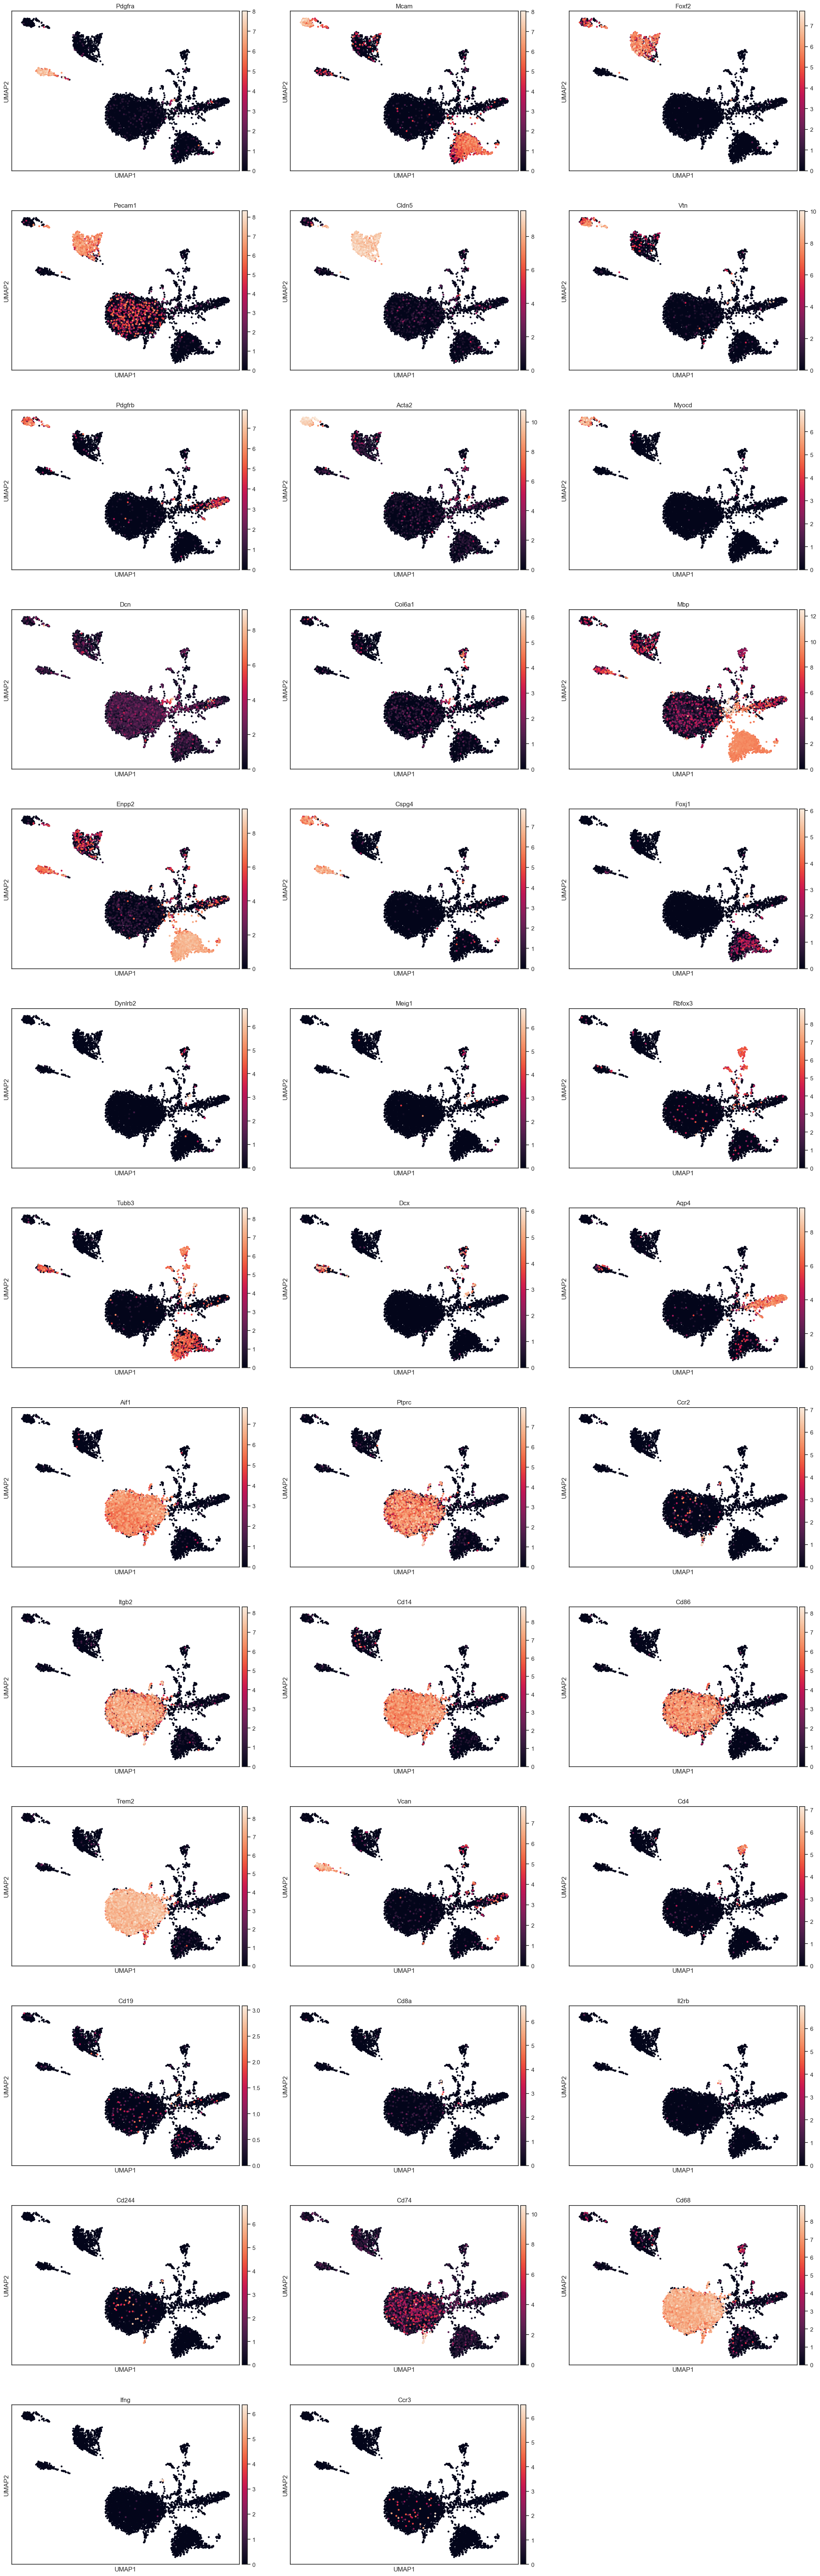

In [76]:
# plot marker genes
plt.rcParams['figure.figsize'] = [8, 6] # set plot sizes
marker_genes = ["Pdgfra", "Mcam","Foxf2", "Pecam1", "Cldn5","Vtn", "Pdgfrb","Acta2", "Myocd","Dcn", "Col6a1", "Mbp","Enpp2","Cspg4","Pifo","Foxj1","Dynlrb2","Meig1","Rbfox3","Tubb3","Dcx","Aqp4", "Aif1", "Ptprc", "Ccr2","Adgre1","Itgb2","Cd14","Cd86","Trem2","Vcan","Cd4","Cd19", "Cd8a","Il2rb","Cd244", "Cd74","Cd68","Ifng","Ptgdr2","Ccr3"]
marker_genes=[x for x in marker_genes if x in list(adata.var_names)] # remove those not in adata.var_names
sc.pl.umap(adata, ncols=3, color=marker_genes, size=50)

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


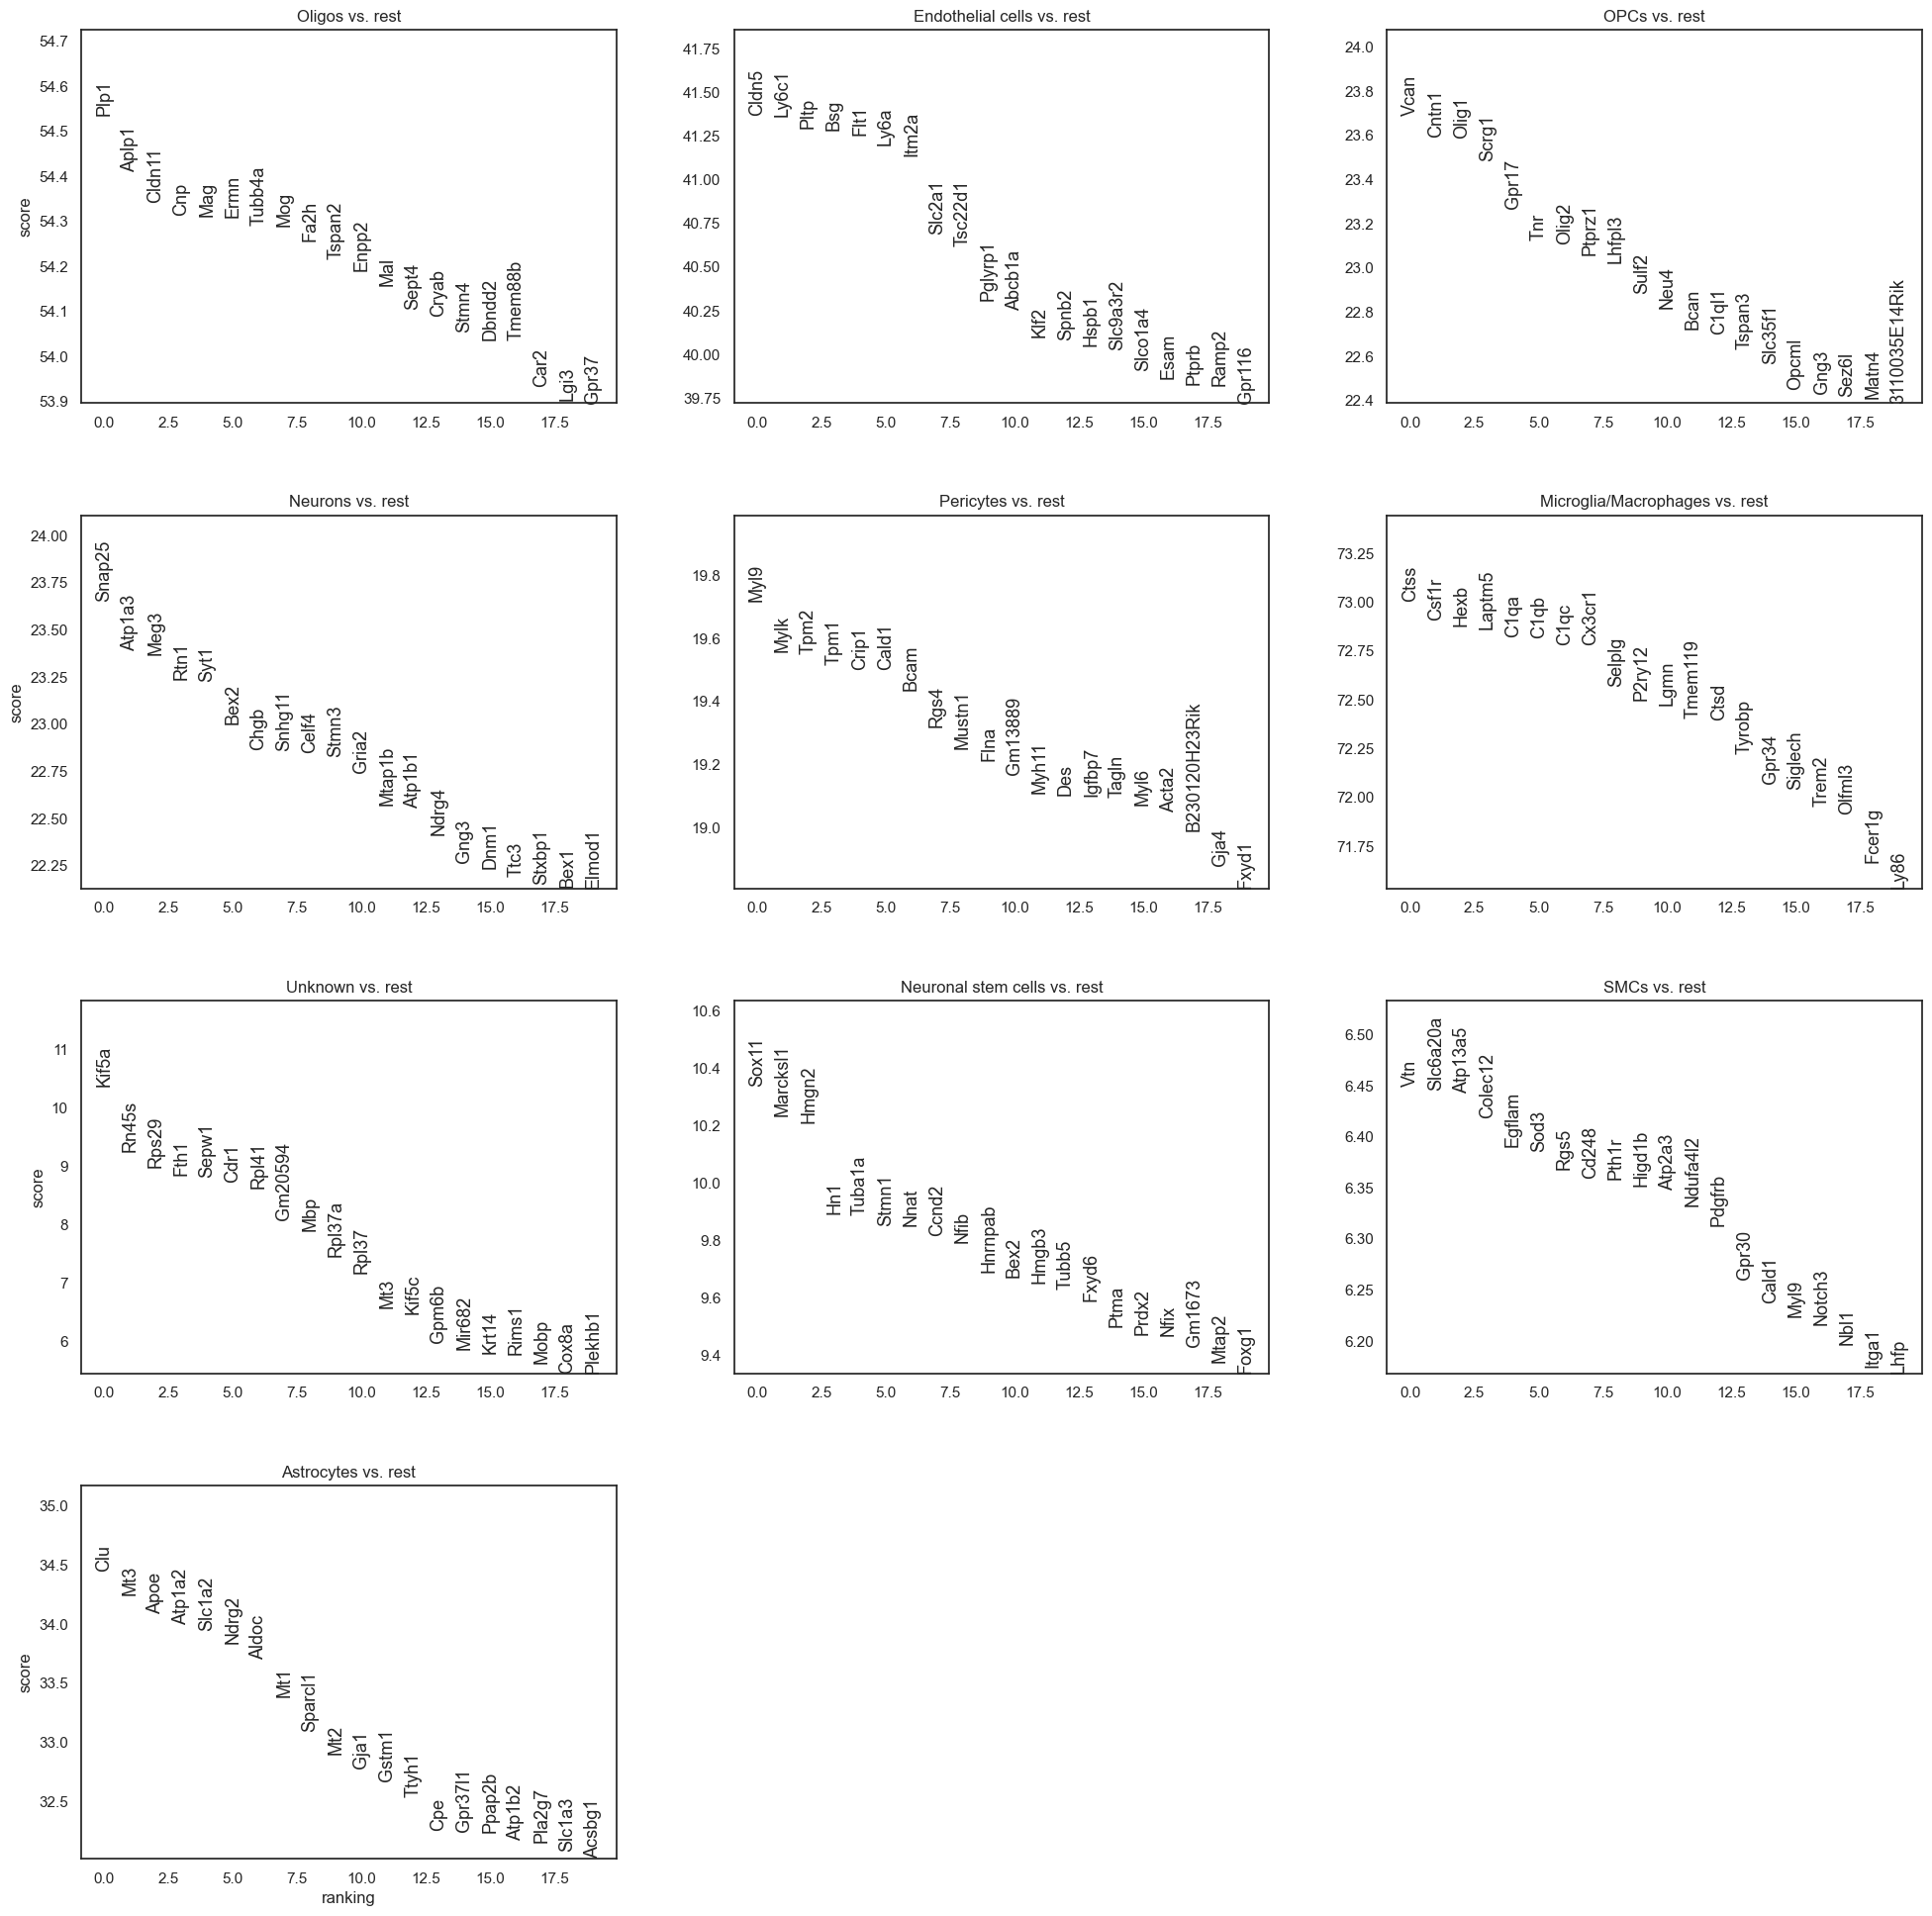

In [77]:
# Run DE test for annotation (Wilcoxon)
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon', key_added='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=3, fontsize=13, key='wilcoxon')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


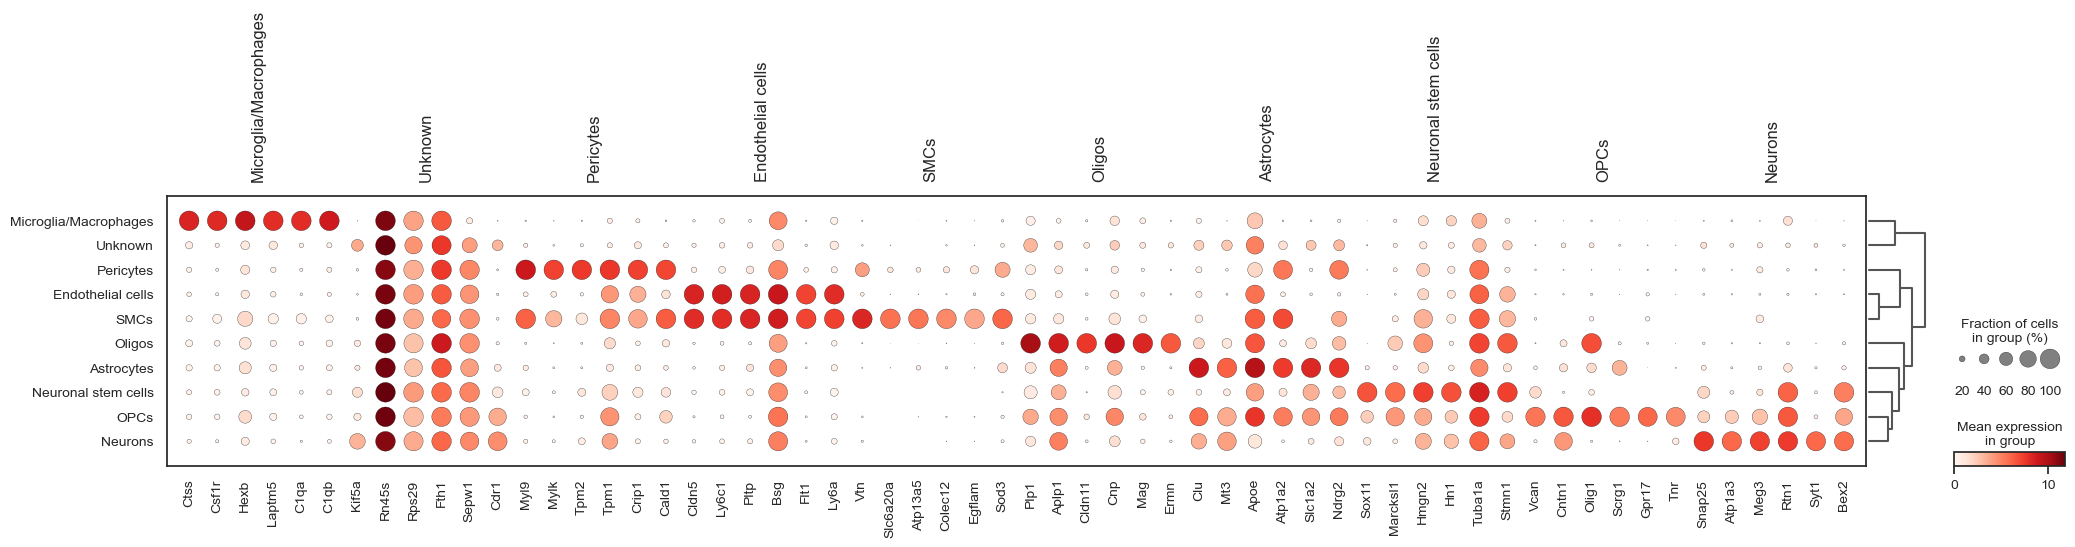

In [78]:
# Dotplot
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, key="wilcoxon", groupby="cell_type");

Own note: The clusters SMCs and Pericytes seem to be wrongly switched. The pericyte markers Vtn, Atp13a5, Pdgfrb are among top SMC hits. Conversely, SMC marker genes are constituting the top hits from the pericyte cluster. Therefore, switch annotations:


In [79]:
adata_tamu = adata
adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'Astrocytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte'])] =  'Oligos'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['endothelial cell'])] =  'Endothelial cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte precursor cell'])] =  'OPCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuron'])] =  'Neurons'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['brain pericyte'])] =  'SMCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['macrophage','microglial cell'])] =  'Microglia/Macrophages'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['unknown'])] =  'Unknown'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuronal stem cell'])] =  'Neuronal stem cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['smooth muscle cell'])] =  'Pericytes'
adata = adata_tamu
del adata_tamu

In [80]:
adata.obs['cell_type'] = adata.obs['cell_type'].cat.remove_unused_categories()

In [81]:
adata.obs['cell_type'].value_counts()

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
SMCs                      132
Neuronal stem cells        36
Pericytes                  14
Name: cell_type, dtype: int64

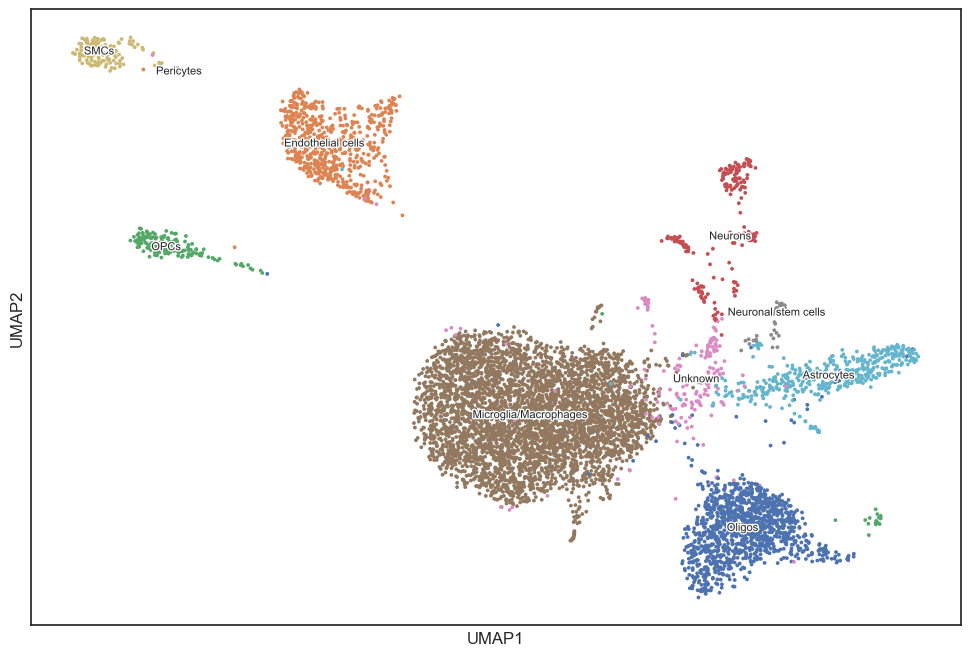

In [82]:
plt.rcParams['figure.figsize'] = [12, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=2, legend_fontsize=8, size=30)

# Focus on: Foxf2

In [83]:
gene="Foxf2"

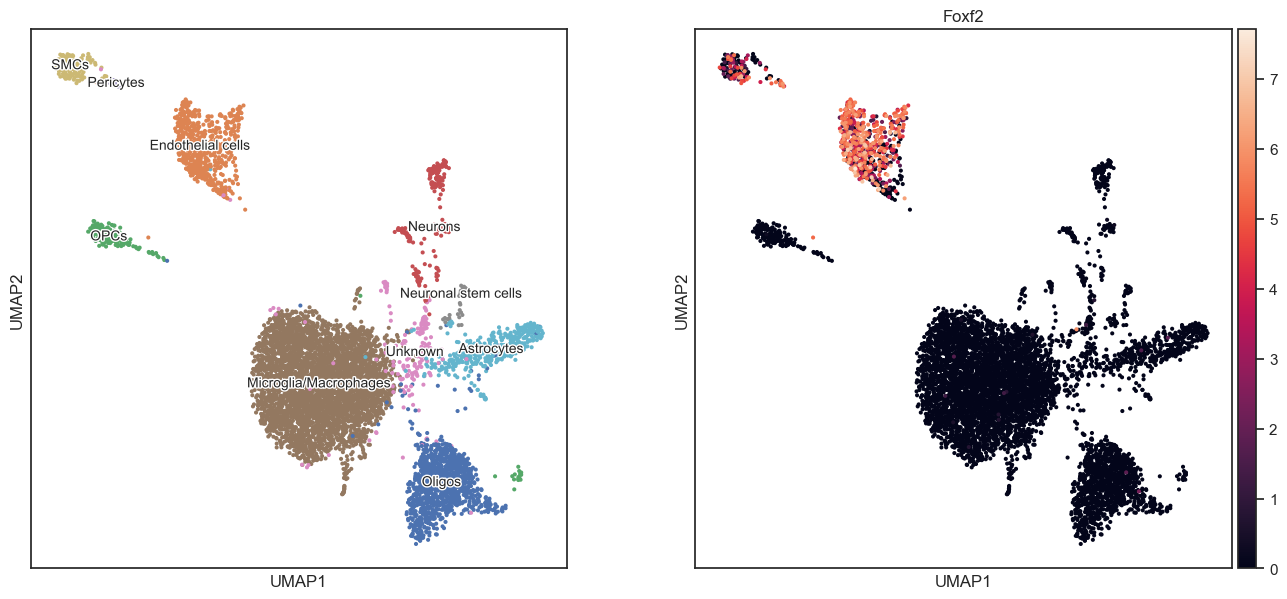

In [84]:
with rc_context({'figure.figsize': (7,7)}):
    sc.pl.umap(adata, color=['cell_type',gene], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=2, legend_fontsize=10, size=35, layer="normalized")

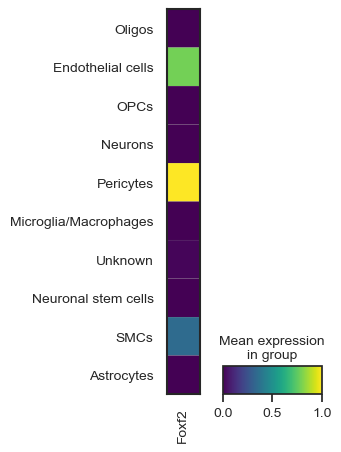

In [85]:
sc.pl.matrixplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [86]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
cell_type                             
Oligos                        0.000781
Endothelial cells             0.786450
OPCs                          0.000305
Neurons                       0.000694
Pericytes                     1.000000
Microglia/Macrophages         0.000449
Unknown                       0.015426
Neuronal stem cells           0.000000
SMCs                          0.345166
Astrocytes                    0.001768

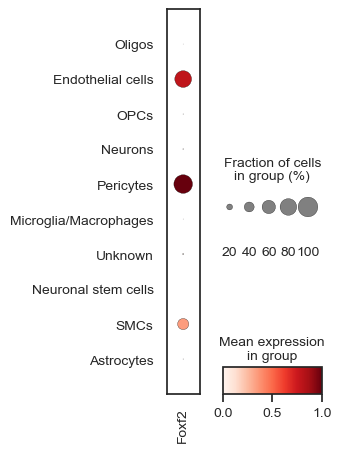

In [87]:
sc.pl.dotplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [88]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
cell_type                               
Oligos                          0.001686
Endothelial cells               0.806400
OPCs                            0.004950
Neurons                         0.010204
Pericytes                       0.928571
Microglia/Macrophages           0.002291
Unknown                         0.022727
Neuronal stem cells             0.000000
SMCs                            0.469697
Astrocytes                      0.004619

In [89]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "TabulaMuris2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["cell_type"].value_counts()).reindex(foxf2.index)
foxf2.index.name = "clusters"
foxf2

mean_expression  fraction_of_cells   gene  \
clusters                                                           
Oligos                        0.000781           0.001686  Foxf2   
Endothelial cells             0.786450           0.806400  Foxf2   
OPCs                          0.000305           0.004950  Foxf2   
Neurons                       0.000694           0.010204  Foxf2   
Pericytes                     1.000000           0.928571  Foxf2   
Microglia/Macrophages         0.000449           0.002291  Foxf2   
Unknown                       0.015426           0.022727  Foxf2   
Neuronal stem cells           0.000000           0.000000  Foxf2   
SMCs                          0.345166           0.469697  Foxf2   
Astrocytes                    0.001768           0.004619  Foxf2   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Pericytes              TabulaMuris2018    Mouse           14  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
Neuronal stem cells    TabulaMuris2018    Mouse           36  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [90]:
# export
name='TabulaMuris2018'

In [91]:
# Win + Linux
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_normalized.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [92]:
gene="Foxo1"

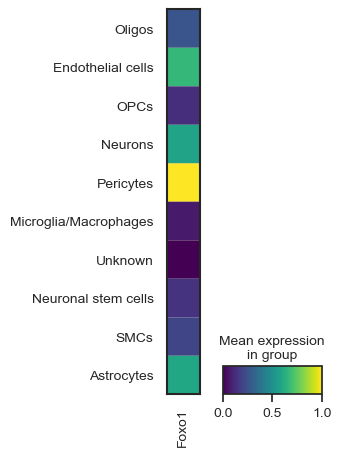

In [93]:
sc.pl.matrixplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [94]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
cell_type                             
Oligos                        0.263385
Endothelial cells             0.664885
OPCs                          0.131718
Neurons                       0.579136
Pericytes                     1.000000
Microglia/Macrophages         0.070205
Unknown                       0.000000
Neuronal stem cells           0.147154
SMCs                          0.206156
Astrocytes                    0.594899

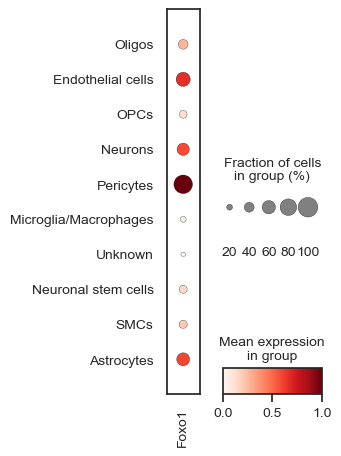

In [95]:
sc.pl.dotplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [96]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
cell_type                               
Oligos                          0.392074
Endothelial cells               0.646400
OPCs                            0.287129
Neurons                         0.535714
Pericytes                       0.928571
Microglia/Macrophages           0.202520
Unknown                         0.142045
Neuronal stem cells             0.305556
SMCs                            0.310606
Astrocytes                      0.572748

In [97]:
foxo1 = pd.concat([ex, fc], axis=1)
foxo1['gene'] = gene
foxo1['source'] = "TabulaMuris2018"
foxo1['organism'] = "Mouse"
foxo1['cell_number'] = pd.DataFrame(adata.obs["cell_type"].value_counts()).reindex(foxo1.index)
foxo1

mean_expression  fraction_of_cells   gene  \
cell_type                                                          
Oligos                        0.263385           0.392074  Foxo1   
Endothelial cells             0.664885           0.646400  Foxo1   
OPCs                          0.131718           0.287129  Foxo1   
Neurons                       0.579136           0.535714  Foxo1   
Pericytes                     1.000000           0.928571  Foxo1   
Microglia/Macrophages         0.070205           0.202520  Foxo1   
Unknown                       0.000000           0.142045  Foxo1   
Neuronal stem cells           0.147154           0.305556  Foxo1   
SMCs                          0.206156           0.310606  Foxo1   
Astrocytes                    0.594899           0.572748  Foxo1   

                                source organism  cell_number  
cell_type                                                     
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Pericytes              TabulaMuris2018    Mouse           14  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
Neuronal stem cells    TabulaMuris2018    Mouse           36  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [98]:
# export
name='TabulaMuris2018'

In [99]:
# Win
foxo1.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Tek = Tie2

In [100]:
gene="Tek"

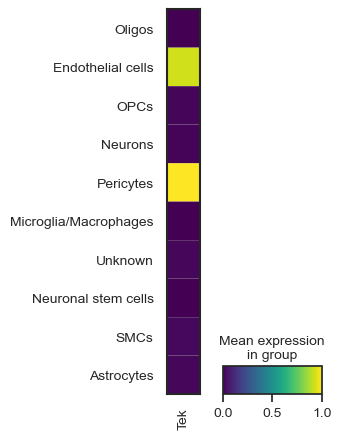

In [101]:
sc.pl.matrixplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [102]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
cell_type                             
Oligos                        0.003092
Endothelial cells             0.927908
OPCs                          0.011903
Neurons                       0.010029
Pericytes                     1.000000
Microglia/Macrophages         0.003140
Unknown                       0.017804
Neuronal stem cells           0.000000
SMCs                          0.022764
Astrocytes                    0.016723

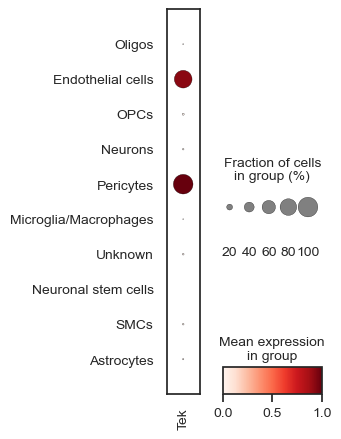

In [103]:
sc.pl.dotplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [104]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
cell_type                               
Oligos                          0.018550
Endothelial cells               0.872000
OPCs                            0.049505
Neurons                         0.035714
Pericytes                       1.000000
Microglia/Macrophages           0.015808
Unknown                         0.039773
Neuronal stem cells             0.000000
SMCs                            0.037879
Astrocytes                      0.030023

In [105]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["cell_type"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells gene  \
cell_type                                                        
Oligos                        0.003092           0.018550  Tek   
Endothelial cells             0.927908           0.872000  Tek   
OPCs                          0.011903           0.049505  Tek   
Neurons                       0.010029           0.035714  Tek   
Pericytes                     1.000000           1.000000  Tek   
Microglia/Macrophages         0.003140           0.015808  Tek   
Unknown                       0.017804           0.039773  Tek   
Neuronal stem cells           0.000000           0.000000  Tek   
SMCs                          0.022764           0.037879  Tek   
Astrocytes                    0.016723           0.030023  Tek   

                                source organism  cell_number  
cell_type                                                     
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Pericytes              TabulaMuris2018    Mouse           14  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
Neuronal stem cells    TabulaMuris2018    Mouse           36  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [106]:
# export
name='TabulaMuris2018'

In [107]:
# Win
tek.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

## Nos3 = eNOS

In [108]:
gene="Nos3"

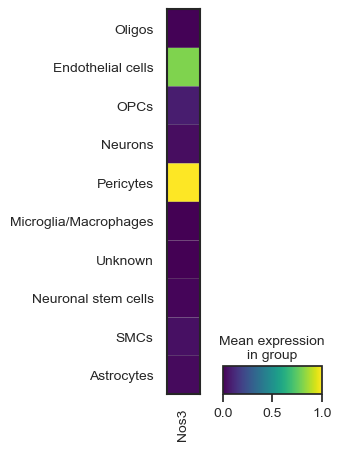

In [109]:
sc.pl.matrixplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [110]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
cell_type                             
Oligos                        0.005609
Endothelial cells             0.807857
OPCs                          0.078279
Neurons                       0.034220
Pericytes                     1.000000
Microglia/Macrophages         0.002185
Unknown                       0.000000
Neuronal stem cells           0.014062
SMCs                          0.039180
Astrocytes                    0.024098

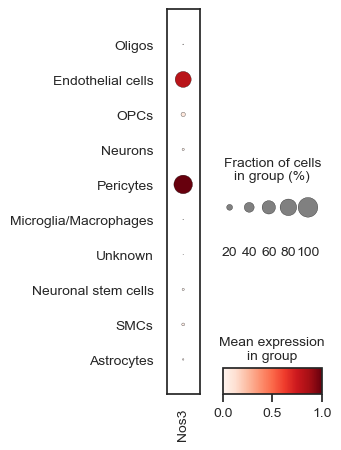

In [111]:
sc.pl.dotplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [112]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='cell_type', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
cell_type                               
Oligos                          0.013491
Endothelial cells               0.761600
OPCs                            0.133663
Neurons                         0.056122
Pericytes                       0.928571
Microglia/Macrophages           0.008935
Unknown                         0.005682
Neuronal stem cells             0.055556
SMCs                            0.075758
Astrocytes                      0.032333

In [113]:
tek = pd.concat([ex, fc], axis=1)
tek['gene'] = gene
tek['source'] = "TabulaMuris2018"
tek['organism'] = "Mouse"
tek['cell_number'] = pd.DataFrame(adata.obs["cell_type"].value_counts()).reindex(tek.index)
tek

mean_expression  fraction_of_cells  gene  \
cell_type                                                         
Oligos                        0.005609           0.013491  Nos3   
Endothelial cells             0.807857           0.761600  Nos3   
OPCs                          0.078279           0.133663  Nos3   
Neurons                       0.034220           0.056122  Nos3   
Pericytes                     1.000000           0.928571  Nos3   
Microglia/Macrophages         0.002185           0.008935  Nos3   
Unknown                       0.000000           0.005682  Nos3   
Neuronal stem cells           0.014062           0.055556  Nos3   
SMCs                          0.039180           0.075758  Nos3   
Astrocytes                    0.024098           0.032333  Nos3   

                                source organism  cell_number  
cell_type                                                     
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Pericytes              TabulaMuris2018    Mouse           14  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
Neuronal stem cells    TabulaMuris2018    Mouse           36  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

In [114]:
# export
name='TabulaMuris2018'

In [115]:
# Win
tek.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+"_"+name+'_normalized.csv',sep=';')

# Session Info

In [116]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.3.0
h5py                        3.6.0
hypergeom_ufunc             NA
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.7.0
jedi                        0.18.1
jinja2 